In [ ]:
!pip install pygame

In [ ]:
!pip install box2d-py
!pip install Box2D
!pip install gym[box2d]

  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generati

Using device: cuda
Starting PPO training with improved hyperparameters...

PPO Update 1/50: Test Return: -119.06
PPO Update 2/50: Test Return: -115.62
PPO Update 3/50: Test Return: -118.32
PPO Update 4/50: Test Return: -121.16
PPO Update 5/50: Test Return: -136.18
PPO Update 6/50: Test Return: -141.61
PPO Update 7/50: Test Return: -148.20
PPO Update 8/50: Test Return: -131.26
PPO Update 9/50: Test Return: -158.16
PPO Update 10/50: Test Return: -129.24
PPO Update 11/50: Test Return: -118.36
PPO Update 12/50: Test Return: -130.70
PPO Update 13/50: Test Return: -113.59
PPO Update 14/50: Test Return: -113.54
PPO Update 15/50: Test Return: -116.13
PPO Update 16/50: Test Return: -123.07
PPO Update 17/50: Test Return: -118.15
PPO Update 18/50: Test Return: -171.02
PPO Update 19/50: Test Return: -171.69
PPO Update 20/50: Test Return: -170.79
PPO Update 21/50: Test Return: -145.45
PPO Update 22/50: Test Return: -126.69
PPO Update 23/50: Test Return: -126.74
PPO Update 24/50: Test Return: -124.7

ValueError: x and y must have same first dimension, but have shapes (100,) and (50,)

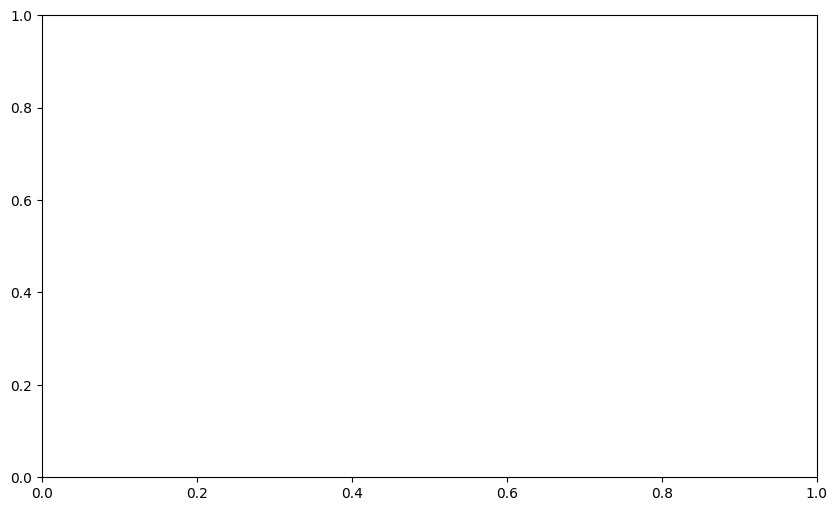

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Policy network for continuous actions.
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_size=128):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        mean = self.mean(x)
        std = torch.exp(self.log_std)
        return mean, std

# Value network for PPO.
class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden_size=128):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.value(x)

###########################
# Utility Functions
###########################

def compute_discounted_returns(rewards, gamma):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

def run_episode(policy, env, max_steps, render=False):
    obs = env.reset()
    total_reward = 0
    done = False
    step = 0
    while not done and step < max_steps:
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        with torch.no_grad():
            mean, std = policy(obs_tensor)
        dist = Normal(mean, std)
        action = dist.sample()
        action_np = action.squeeze(0).cpu().detach().numpy()
        obs, reward, done, _ = env.step(action_np)
        total_reward += reward
        step += 1
        if render:
            env.render()
    return total_reward

###########################
# PPO Implementation
###########################

def collect_trajectories_ppo(policy, value_net, env, min_steps_per_batch, gamma):
    trajectories = []
    total_steps = 0
    while total_steps < min_steps_per_batch:
        obs = env.reset()
        episode = {'observations': [],
                   'actions': [],
                   'log_probs': [],
                   'rewards': [],
                   'values': []}
        done = False
        while not done:
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            with torch.no_grad():
                value = value_net(obs_tensor)
                mean, std = policy(obs_tensor)
            dist = Normal(mean, std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)
            action_np = action.squeeze(0).cpu().detach().numpy()

            episode['observations'].append(obs)
            episode['actions'].append(action_np)
            episode['log_probs'].append(log_prob)
            episode['values'].append(value.item())

            obs, reward, done, _ = env.step(action_np)
            episode['rewards'].append(reward)
            total_steps += 1
            if done:
                break
        trajectories.append(episode)
    return trajectories

def train_ppo(env_name="BipedalWalker-v3", num_updates=100, min_steps_per_batch=4000,
              gamma=0.99, clip_epsilon=0.2, ppo_epochs=10, lr=3e-4, max_steps=3000):
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    policy = Policy(obs_dim, act_dim).to(device)
    value_net = ValueNet(obs_dim).to(device)
    optimizer = optim.Adam(list(policy.parameters()) + list(value_net.parameters()), lr=lr)

    ppo_test_returns = []
    print("Starting PPO training with improved hyperparameters...\n")
    for update in range(num_updates):
        trajectories = collect_trajectories_ppo(policy, value_net, env, min_steps_per_batch, gamma)

        observations, actions, log_probs_old, returns, advantages = [], [], [], [], []

        for ep in trajectories:
            ep_returns = compute_discounted_returns(ep['rewards'], gamma)
            ep_advantages = np.array(ep_returns) - np.array(ep['values'])
            observations.extend(ep['observations'])
            actions.extend(ep['actions'])
            log_probs_old.extend([lp.detach() for lp in ep['log_probs']])
            returns.extend(ep_returns)
            advantages.extend(ep_advantages)

        observations = torch.FloatTensor(observations).to(device)
        actions = torch.FloatTensor(actions).to(device)
        log_probs_old = torch.stack(log_probs_old).to(device)
        returns = torch.FloatTensor(returns).to(device)
        advantages = torch.FloatTensor(advantages).to(device)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update: several epochs over the batch.
        for _ in range(ppo_epochs):
            mean, std = policy(observations)
            dist = Normal(mean, std)
            log_probs = dist.log_prob(actions).sum(dim=-1)
            entropy = dist.entropy().sum(dim=-1).mean()
            ratio = torch.exp(log_probs - log_probs_old)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            value_estimates = value_net(observations).squeeze()
            value_loss = nn.MSELoss()(value_estimates, returns)

            loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        test_return = run_episode(policy, env, max_steps=max_steps)
        ppo_test_returns.append(test_return)
        print(f"PPO Update {update+1}/{num_updates}: Test Return: {test_return:.2f}")

    env.close()
    return ppo_test_returns

###########################
# GRPO Implementation
###########################

def collect_trajectories_grpo(policy, env, group_size, max_steps):
    trajectories = []
    # Use a fixed seed for each rollout for similar initial conditions.
    for i in range(group_size):
        obs = env.reset(seed=42)
        episode = {'observations': [],
                   'actions': [],
                   'log_probs': [],
                   'rewards': []}
        done = False
        step = 0
        while not done and step < max_steps:
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            mean, std = policy(obs_tensor)
            dist = Normal(mean, std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)
            action_np = action.squeeze(0).cpu().detach().numpy()

            episode['observations'].append(obs)
            episode['actions'].append(action_np)
            episode['log_probs'].append(log_prob)

            obs, reward, done, _ = env.step(action_np)
            episode['rewards'].append(reward)
            step += 1
        trajectories.append(episode)
    return trajectories

def train_grpo(env_name="BipedalWalker-v3", num_updates=100, group_size=10, max_steps=3000, lr=3e-4):
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    policy = Policy(obs_dim, act_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    grpo_test_returns = []
    print("\nStarting GRPO training with improved hyperparameters...\n")
    for update in range(num_updates):
        trajectories = collect_trajectories_grpo(policy, env, group_size, max_steps)
        episode_returns = [np.sum(ep['rewards']) for ep in trajectories]
        group_baseline = np.mean(episode_returns)

        loss = 0
        for ep in trajectories:
            advantage = np.sum(ep['rewards']) - group_baseline
            for log_prob in ep['log_probs']:
                loss -= log_prob * advantage
        loss = loss / group_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        test_return = run_episode(policy, env, max_steps=max_steps)
        grpo_test_returns.append(test_return)
        print(f"GRPO Update {update+1}/{num_updates}: Group Baseline: {group_baseline:.2f}, Test Return: {test_return:.2f}")

    env.close()
    return grpo_test_returns

###########################
# Run and Plot Comparisons
###########################

if __name__ == '__main__':
    # Run PPO training with the updated hyperparameters.
    ppo_returns = train_ppo(env_name="BipedalWalker-v3", num_updates=50, min_steps_per_batch=4000, max_steps=3000)
    # Run GRPO training with the updated hyperparameters.
    grpo_returns = train_grpo(env_name="BipedalWalker-v3", num_updates=50, group_size=10, max_steps=3000)

    # Plot raw test returns over updates.
    updates = np.arange(1, 101)
    plt.figure(figsize=(10, 6))
    plt.plot(updates, ppo_returns, label="PPO", marker='o')
    plt.plot(updates, grpo_returns, label="GRPO", marker='x')
    plt.xlabel("Update")
    plt.ylabel("Test Return")
    plt.title("PPO vs GRPO Performance on BipedalWalker-v3 (Improved Hyperparameters)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot smoothed curves using a moving average (window size=5).
    window = 5
    ppo_smoothed = np.convolve(ppo_returns, np.ones(window)/window, mode='valid')
    grpo_smoothed = np.convolve(grpo_returns, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(window, 101), ppo_smoothed, label="PPO Smoothed", marker='o')
    plt.plot(np.arange(window, 101), grpo_smoothed, label="GRPO Smoothed", marker='x')
    plt.xlabel("Update")
    plt.ylabel("Smoothed Test Return")
    plt.title("Smoothed PPO vs GRPO Performance (Improved Hyperparameters)")
    plt.legend()
    plt.grid(True)
    plt.show()
s

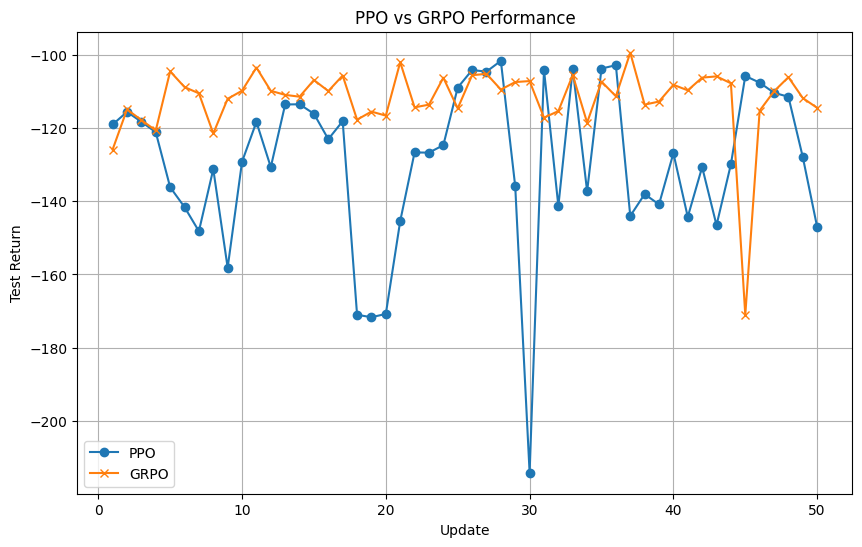

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# PPO test returns from your logs.
ppo_returns = [
    -119.06, -115.62, -118.32, -121.16, -136.18, -141.61, -148.20, -131.26, -158.16, -129.24,
    -118.36, -130.70, -113.59, -113.54, -116.13, -123.07, -118.15, -171.02, -171.69, -170.79,
    -145.45, -126.69, -126.74, -124.71, -108.98, -104.20, -104.62, -101.68, -135.95, -214.15,
    -104.14, -141.34, -103.83, -137.32, -103.78, -102.87, -144.04, -138.08, -140.88, -126.90,
    -144.30, -130.69, -146.56, -129.92, -105.80, -107.64, -110.40, -111.49, -127.96, -147.07
]

# GRPO test returns from your logs.
grpo_returns = [
    -125.89, -114.95, -117.85, -120.69, -104.55, -108.84, -110.55, -121.51, -112.04, -109.84,
    -103.52, -109.87, -110.97, -111.47, -106.92, -109.93, -105.69, -117.74, -115.54, -116.64,
    -102.05, -114.38, -113.64, -106.29, -114.66, -105.60, -105.22, -109.52, -107.47, -107.20,
    -117.20, -115.40, -105.54, -118.55, -107.34, -111.35, -99.46, -113.64, -112.79, -108.22,
    -109.73, -106.26, -105.92, -107.80, -171.07, -115.28, -109.99, -106.14, -111.84, -114.52
]

# Create an array of update numbers.
updates = np.arange(1, 51)

# Plot the raw test returns.
plt.figure(figsize=(10, 6))
plt.plot(updates, ppo_returns, label="PPO", marker='o')
plt.plot(updates, grpo_returns, label="GRPO", marker='x')
plt.xlabel("Update")
plt.ylabel("Test Return")
plt.title("PPO vs GRPO Performance")
plt.legend()
plt.grid(True)
plt.show()
